# Importing libraries

In [3]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import pickle
import os
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
from sklearn.cross_validation import train_test_split
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load pickle files

In [4]:
ans_pairs = pickle.load(open("./pairs","rb"))    #reference answer and student answer
labels = pickle.load(open("./labels","rb"))      #correct or incorrect are the labels

In [5]:
print(len(labels))   # number of labels
print(len(ans_pairs)) #number of question pairs
print(len(list(set(labels))))

4969
4969
2


In [6]:
correctans_pair=[]
incorrectans_pair = []
poslabels = []
neglabels = []
reference = ans_pairs[0][0]
for i in range(len(labels)):
    if labels[i]==1:
        correctans_pair.append(ans_pairs[i])
        poslabels.append(labels[i])
    else:
        incorrectans_pair.append(ans_pairs[i])
        neglabels.append(labels[i])
print(len(correctans_pair),len(poslabels))
print(len(incorrectans_pair),len(neglabels))

2008 2008
2961 2961


In [7]:
anchor_pair = []
correct_answer_pair = []
wrong_answer = []
trainlabels = []
k=1
for i in correctans_pair:
    print(k)
    for j in incorrectans_pair:
        if i[0] in j[0]:
            anchor_pair.append(i[0])
            correct_answer_pair.append(i[1])
            wrong_answer.append(j[1])
            trainlabels.append(1)
        else:
            continue
    k=k+1
print(len(anchor_pair),len(correct_answer_pair),len(wrong_answer))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
BASE_DIR = './glove.6B/'
max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
MAX_SEQUENCE_LENGTH = 20

EMBEDDING_DIM = 100

embeddings_index = {}
f = open(os.path.join(BASE_DIR, 'glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word.lower()] = coefs
f.close()

word_cindex={}
c=0
for word in embeddings_index:
    word_cindex[word]=c
    c+=1

In [9]:
nb_words=len(set(word_cindex))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_cindex.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        if embedding_vector.shape[0]<EMBEDDING_DIM:
            embedding_vector=np.hstack([embedding_vector,[0]])
    # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
def text_to_vector(answerlist):
    vocab = {}
    for line in answerlist:
        a=line.split()
        for i in a:
            if i in vocab:
                vocab[i]+=1
            else:
                vocab[i]=1
    nb_words = len(vocab)
    MAX_NB_WORDS=nb_words
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(answerlist)
    sequences = tokenizer.texts_to_sequences(answerlist)
    word_index = tokenizer.word_index
    return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [11]:
reference_features = text_to_vector(anchor_pair)
reference_features = pd.DataFrame(reference_features)
print(reference_features.shape)
stuanswer_features = text_to_vector(correct_answer_pair)
stuanswer_features = pd.DataFrame(stuanswer_features)
print(stuanswer_features.shape)
stuneganswer_features = text_to_vector(wrong_answer)
stuneganswer_features = pd.DataFrame(stuneganswer_features)
print(stuneganswer_features.shape)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(36735, 20)
(36735, 20)
(36735, 20)


In [12]:
X1_train, X1_val, X2_train, X2_val, X3_train, X3_val, y_train, y_val = \
    train_test_split(reference_features, 
                     stuanswer_features,
                     stuneganswer_features,
                     trainlabels,
                     test_size=0.3)

In [13]:
print(X1_train.shape)    # Reference answer training data
print(X1_val.shape)      # Reference answer validation data
print(X2_train.shape)    # Student answer training data
print(X2_val.shape)      # student answer validation data
print(X3_train.shape)    
print(len(y_train))      # labels in training
print(len(y_val))       # labels in testing

(25714, 20)
(11021, 20)
(25714, 20)
(11021, 20)
(25714, 20)
25714
11021


In [59]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 50
n_epoch = 1

In [15]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [58]:
ALPHA = 0.2  # Triplet Loss Parameter
def triplet_loss(x):
    anchor, positive, negative = x

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
    print(pos_dist,neg_dist,pos_dist-neg_dist)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)

    return loss

In [25]:
# The visible layer
left_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
right_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
anchor_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [54]:
embedding_layer = Embedding(nb_words + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)
encoded_anchor = embedding_layer(anchor_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

anchor_output = shared_lstm(encoded_anchor)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)


# Calculates the distance as defined by the MaLSTM model
restlstm_distance = Merge(mode=triplet_loss, output_shape=lambda x: (x[0][0], 1))([anchor_output,left_output, right_output])

# Pack it all up into a model
restlstm = Model([anchor_input,left_input, right_input], [restlstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

restlstm.compile(loss='mse', optimizer="adam", metrics=['accuracy'])

Tensor("merge_4/Sum:0", shape=(?,), dtype=float32) Tensor("merge_4/Sum_1:0", shape=(?,), dtype=float32) Tensor("merge_4/sub:0", shape=(?,), dtype=float32)


/home/adithya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [60]:
# Start training
training_start_time = time()

restlstm_trained = restlstm.fit([X1_train, X2_train,X3_train], np.array(y_train), batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X1_val, X2_val,X3_val], np.array(y_val)))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 25714 samples, validate on 11021 samples
Epoch 1/1
25714/25714 [==============================] - 438s 17ms/step - loss: 0.0234 - acc: 0.9981 - val_loss: 0.0187 - val_acc: 1.0000
Training time finished.
1 epochs in 0:07:18.126703


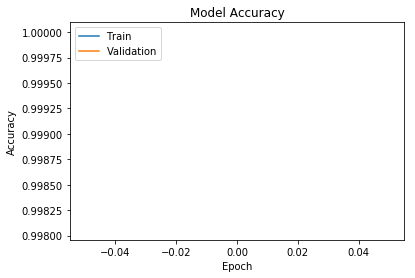

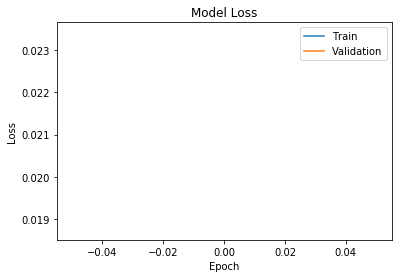

In [61]:
# Plot accuracy
plt.plot(restlstm_trained.history['acc'])
plt.plot(restlstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(restlstm_trained.history['loss'])
plt.plot(restlstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [62]:
Y_pred = restlstm_trained.model.predict([X1_val,X2_val,X3_val])

In [67]:
import math
y_pred = []
testlabels = []
for i in range(len(Y_pred)):
    if(Y_pred[i]-y_val[i]<0.2):
        testlabels.append(1)
    else:
        testlabels.append(0)
print(y_pred[0:10])

[]


In [68]:
print(Y_pred.shape)
print(sum((Y_pred-y_val)<0.2))

(11021,)
9261


In [69]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_val,testlabels))
print(confusion_matrix(y_val,testlabels))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.84      0.91     11021

avg / total       1.00      0.84      0.91     11021

[[   0    0]
 [1760 9261]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [72]:
X1_test = X1_val[0:994]
X2_test = X2_val[0:994]
X3_test = X3_val[0:994]

In [73]:
Y_test = restlstm_trained.model.predict([X1_test,X2_test,X3_test])

In [74]:
import math
y_pred = []
test = []
Y_val = y_val[0:994]
for i in range(len(Y_test)):
    if(Y_pred[i]-Y_val[i]<0.2):
        test.append(1)
    else:
        test.append(0)

In [76]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_val,test))
print(confusion_matrix(Y_val,test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.74      0.85       994

avg / total       1.00      0.74      0.85       994

[[  0   0]
 [256 738]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [103]:
print(X1_test[193:200])

        0   1   2    3    4    5    6    7    8   9   10  11  12  13   14  \
4310     0   0   0    0    0    0    0    0    0   0   0  17   1  20   26   
4257     0   0   0    0    0    0    0    0    0   0   0  17   1  20   26   
29701    0   0   0  456  161    2   32   21  248  32   3   2  75  37    2   
27820    0   0   0    0    0    0    0    0    0   0   0   0   0   0    0   
15329  424  48  21    1  144  226  182  181    9  48  18  24  36   1  425   
15271  424  48  21    1  144  226  182  181    9  48  18  24  36   1  425   
11400    0   0   0    0    0    0    0    0    0   0   0   0  84   2  102   

        15  16   17   18   19  
4310   119   1   43   26   67  
4257   119   1   43   26   67  
29701   75  37  183    2  123  
27820    0   1   28   29   30  
15329    5  34    1  426   70  
15271    5  34    1  426   70  
11400  159   4  107  180   74  


In [90]:
k=0
for i in range(len(test)):
    if test[i]==0:
        print( i)
        k=k+1
    if k>10:
        break

192
193
194
195
196
197
198
199
200
201
202


In [111]:
anchor_pair[15271]

'C. Black absorbs more heat (energy) than white. Pan C has the most dark surface area so C would heat up the fastest and have the highest temperature.'

In [110]:
correct_answer_pair[15271]

'C. The one with 3 disks could of got hot because it had more disks than A or B. Since it has more disks then it was the one that got the hottest because the sun heat got in it more than the other 2.'

In [106]:
wrong_answer[4310]

'The string made a low pitch.'

In [113]:
restlstm.save_weights("restlstmmodel.h5")
print("Saved model to disk")

Saved model to disk
